In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import os
from original_nbridge_scoring import create_dataframe, check_data, get_missing_data_from_key
from data_functions import create_dataframe, check_data, get_missing_data_from_key, scaling, permutation_null_distro, imputer, get_crit_val, get_significant_components, get_explained_ratio

In [5]:
base_dir = os.path.join(os.environ['HOME'], 'data', 'HCP-disease', 'behavioural')

In [6]:
banda_df = pd.read_excel(os.path.join(base_dir, 'BANDA', 'BehaviouralFiles.xlsx'), sheet_name=None)
ep_df = pd.read_excel(os.path.join(base_dir, 'EP', 'BehaviouralFiles.xlsx'), sheet_name=None)
dcam_df = pd.read_excel(os.path.join(base_dir, 'DCAM', 'DCAM_BehaviouralFiles.xlsx'), sheet_name=None)
pdc_df = pd.read_excel(os.path.join(base_dir, 'PDC', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [8]:
banda_key = pd.read_csv(os.path.join(base_dir, 'BANDA', 'tmp', 'BANDAinfocomplete.csv'))
banda_key['ALL_Data'] = banda_key['ALL_Data'].str.replace('_MR','')
banda_key = banda_key.rename(columns={'ALL_Data': 'src_subject_id'})[['src_subject_id', 'interview_age', 'sex', 'phenotype']]

In [9]:
ep_key = pd.read_csv(os.path.join(base_dir, 'EP', 'tmp', 'EPinfocomplete.csv'))
ep_key = ep_key[['imgkey', 'interview_age',	'sex', 'phenotype']]
ep_key['imgkey'] = ep_key['imgkey'].str.replace('_01_MR', '')
ep_key['phenotype'] = ep_key['phenotype'].str.replace('Patient', 'early_psychosis').str.lstrip()
ep_key = ep_key.rename(columns={'imgkey': 'src_subject_id'})

In [10]:
dcam_key = pd.read_excel(os.path.join(base_dir, 'DCAM', 'DemographicFiles.xlsx'))[1:]
dcam_key = dcam_key[['src_subject_id', 'phenotype', 'sex', 'interview_age']]
dcam_key['phenotype'] = dcam_key['phenotype'].str.replace('Typical', '').str.lstrip()

In [11]:
pdc_key = pd.read_excel(os.path.join(base_dir, 'pdc', 'DemographicFiles.xlsx'))[1:]
pdc_key = pdc_key[['src_subject_id', 'phenotype', 'sex', 'interview_age']]
pdc_key['phenotype'] = pdc_key['phenotype'].str.replace('CONTROL', 'Control').str.replace('TSD Control', 'Control').str.replace('HEALTHY', '').str.lstrip()

In [12]:
banda_ps = create_dataframe(banda_df['pcps01'][1:], banda_key, 'nih_patterncomp_raw')
missing = check_data(banda_ps, banda_key)
banda_ps = pd.concat([banda_ps, banda_key[banda_key['src_subject_id'] == missing[0]]], axis=0).sort_values(by='phenotype').reset_index(drop=True)

In [13]:
ep_ps = create_dataframe(ep_df['pcps01'][1:], ep_key, 'nih_patterncomp_raw')
dcam_ps = create_dataframe(dcam_df['pcps01'][1:], dcam_key, 'nih_patterncomp_raw')
pdc_ps = create_dataframe(pdc_df['pcps01'][1:], pdc_key, 'nih_patterncomp_raw')
missing = check_data(pdc_ps, pdc_key)
pdc_ps = pd.concat([pdc_ps, pdc_key[pdc_key['src_subject_id'] == missing[0]]], axis=0).sort_values(by='phenotype').reset_index(drop=True)

In [14]:
bandas_er = create_dataframe(banda_df['er4001'][1:], banda_key, 'er40_c_cr', 'er40_c_rt')
ep_er = create_dataframe(ep_df['er4001'][1:], ep_key, 'er40_c_cr', 'er40_c_rt')
dcam_er = create_dataframe(dcam_df['er4001'][1:], dcam_key, 'er40_c_cr', 'er40_c_rt')
pdc_er = create_dataframe(pdc_df['er4001'][1:], pdc_key, 'er40_c_cr', 'er40_c_rt')

In [15]:
banda_dccs = create_dataframe(banda_df['dccs01'][1:], banda_key, 'nih_dccs_computed')
banda_dccs = get_missing_data_from_key(banda_dccs, banda_key)
ep_dccs = create_dataframe(ep_df['dccs01'][1:], ep_key, 'nih_dccs_computed')
dcam_dccs = create_dataframe(dcam_df['dccs01'][1:], dcam_key, 'nih_dccs_computed')
pdc_dccs = create_dataframe(pdc_df['dccs01'][1:], pdc_key, 'nih_dccs_computed')
pdc_dccs = get_missing_data_from_key(pdc_dccs, pdc_key)

In [16]:
bandas_flank = create_dataframe(banda_df['flanker01'][1:], banda_key, 'nih_flanker_unadjusted')
bandas_flank = get_missing_data_from_key(bandas_flank, banda_key)
ep_flank = create_dataframe(ep_df['flanker01'][1:], ep_key, 'nih_flanker_unadjusted')
dcam_flank = create_dataframe(dcam_df['flanker01'][1:], dcam_key, 'nih_flanker_unadjusted')
pdc_flank = create_dataframe(pdc_df['flanker01'][1:], pdc_key, 'nih_flanker_unadjusted')
pdc_flank = get_missing_data_from_key(pdc_flank, pdc_key)

In [17]:
bandas_wm = create_dataframe(banda_df['lswmt01'][1:], banda_key, 'tbx_ls')
bandas_wm = get_missing_data_from_key(bandas_wm, banda_key)
ep_wm = create_dataframe(ep_df['lswmt01'][1:], ep_key, 'tbx_ls')
dcam_wm = create_dataframe(dcam_df['lswmt01'][1:], dcam_key, 'tbx_ls')
pdc_wm = create_dataframe(pdc_df['lswmt01'][1:], pdc_key, 'tbx_ls')
pdc_wm = get_missing_data_from_key(pdc_wm, pdc_key)

In [18]:
df = pd.concat([bandas_er, ep_er, dcam_er])
ps = pd.concat([banda_ps['nih_patterncomp_raw'], ep_ps['nih_patterncomp_raw'], 
                dcam_ps['nih_patterncomp_raw']])
dccs = pd.concat([banda_dccs['nih_dccs_computed'], ep_dccs['nih_dccs_computed'], 
                dcam_dccs['nih_dccs_computed']])
flank = pd.concat([bandas_flank ['nih_flanker_unadjusted'], ep_flank['nih_flanker_unadjusted'], 
                dcam_flank['nih_flanker_unadjusted']])
df = pd.concat([df[['src_subject_id', 'phenotype', 'interview_age', 'sex',  'er40_c_cr', 'er40_c_rt']], ps, dccs, flank], axis=1)

In [45]:
df.describe()

,src_subject_id,phenotype,interview_age,sex,er40_c_cr,er40_c_rt,nih_patterncomp_raw,nih_dccs_computed,nih_flanker_unadjusted
count,634,634,634,634,595,595,590,464,582
unique,634,5,177,2,19,494,48,238,46
top,BANDA052,MDD,288,F,37,1680,50,10,103
freq,1,197,27,369,120,5,37,29,41


In [19]:
data_for_pca_data = imputer(df)
data_for_pca_data['sex'] = data_for_pca_data['sex'].apply(lambda x: 0 if x == 'F' else 1)
data_for_pca_data['interview_age'] = data_for_pca_data['interview_age'].astype('float')

In [20]:
decomp = PCA()
scaled_data = scaling(data_for_pca_data[data_for_pca_data.columns[2:]])
alt = decomp.fit_transform(scaled_data)

In [21]:
null_distro = permutation_null_distro(data_for_pca_data[data_for_pca_data.columns[2:]], n_perms=5000)
crti_val = get_crit_val(len(decomp.explained_variance_ratio_), null_distro)
alt_val = get_explained_ratio(decomp, len(decomp.explained_variance_ratio_))

In [22]:
comp = get_significant_components(crti_val, alt_val)
print(f"Component(s) {comp} are sigifiniciant components")

Component(s) [0, 1] are sigifiniciant components


Text(0, 0.5, 'Explained Variance Ratio')

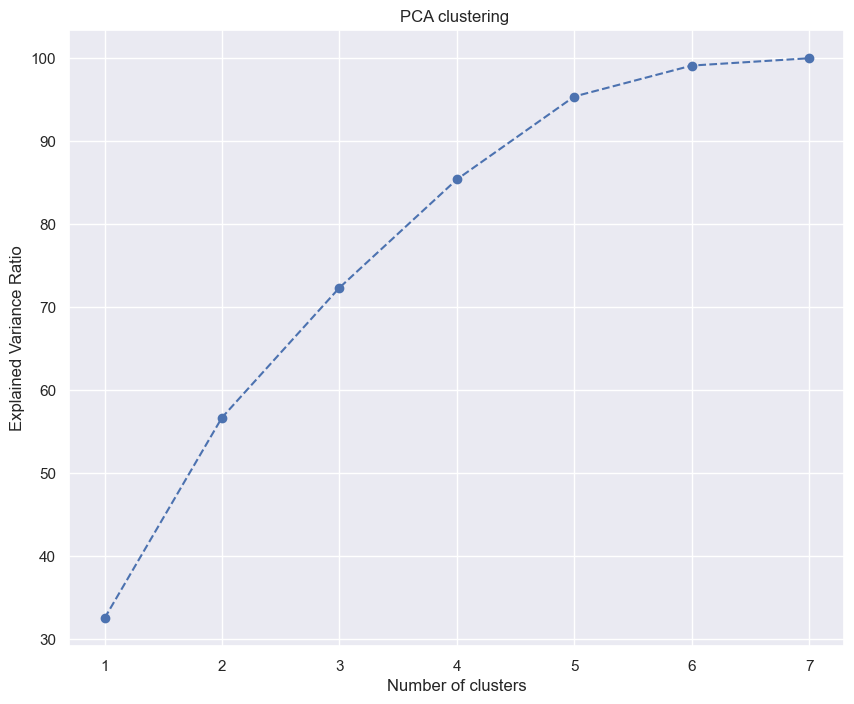

In [23]:
plt.figure(figsize=(10,8))
plt.plot(range(1,len(decomp.explained_variance_ratio_)+1), decomp.explained_variance_ratio_.cumsum()*100, marker='o', linestyle='--')
plt.title('PCA clustering ')
plt.xlabel('Number of clusters')
plt.ylabel('Explained Variance Ratio')

In [24]:
scaled_data = scaling(data_for_pca_data[data_for_pca_data.columns[2:]])
alt_pca = PCA(n_components=2).fit_transform(scaled_data.values)

In [25]:
cluster_range = range(2, 11)
for cluster_n in cluster_range:
    clusterer = KMeans(n_clusters=cluster_n, random_state=10)
    cluster_labels = clusterer.fit_predict(alt_pca)
    silhouette_avg = silhouette_score(alt_pca, cluster_labels)
    print("For n_clusters =", cluster_n, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.550759189203228
For n_clusters = 3 The average silhouette_score is : 0.5556223557823263
For n_clusters = 4 The average silhouette_score is : 0.5534810771563192
For n_clusters = 5 The average silhouette_score is : 0.4753514235091341
For n_clusters = 6 The average silhouette_score is : 0.460613549867447
For n_clusters = 7 The average silhouette_score is : 0.3925565178434482
For n_clusters = 8 The average silhouette_score is : 0.3911958316181928
For n_clusters = 9 The average silhouette_score is : 0.39329254080370074
For n_clusters = 10 The average silhouette_score is : 0.3794411082891843


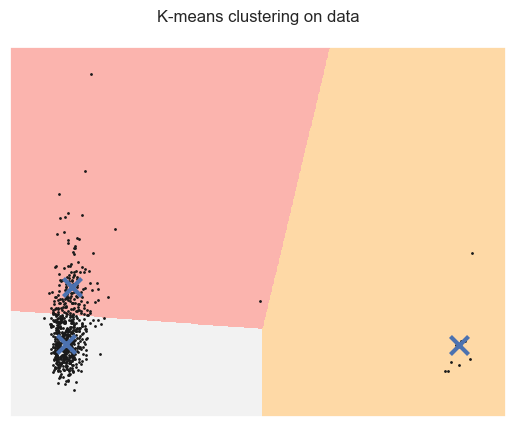

In [26]:
import matplotlib.pyplot as plt

reduced_data = alt_pca
n_digits = 3
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Pastel1,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="b",
    zorder=10,
)
plt.title(
    "K-means clustering on data\n"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

<Axes: ylabel='Count'>

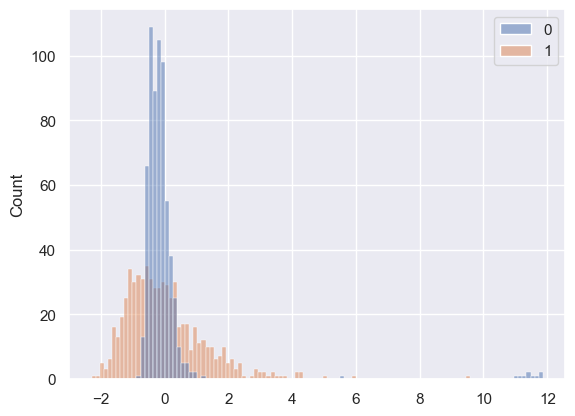

In [27]:
sns.histplot(alt_pca)

In [29]:
alt_pca[:, 0]

array([-2.85591096e-01, -2.71805173e-01, -4.36369241e-01, -4.91518890e-01,
       -5.24672801e-01, -4.17234373e-01, -5.62649400e-01, -5.53054472e-01,
       -4.72817194e-01, -4.45404484e-01, -4.68750642e-01, -4.56342910e-01,
       -4.54010554e-01, -4.30311347e-01, -4.84360720e-01, -5.14467691e-01,
       -4.87900067e-01, -7.14207806e-01, -5.07753096e-01, -4.79610523e-01,
       -5.26710179e-01, -3.95507059e-01, -6.12741611e-01, -4.41664103e-01,
       -4.95338905e-01, -2.93731919e-01, -3.78223059e-01, -4.97709015e-01,
       -3.40893536e-01, -5.42013823e-01, -5.22263622e-01, -6.51278860e-01,
       -5.57856250e-01, -4.37415551e-01, -4.93229716e-01, -5.18632888e-01,
       -1.77370917e-01, -2.95166612e-01, -4.46270355e-01, -2.85192395e-01,
       -3.00731309e-01, -2.49995526e-01, -4.67060691e-01, -4.21265932e-01,
       -3.90385064e-01, -5.38269687e-01, -4.88877900e-01, -4.39334535e-01,
       -5.06505784e-01, -6.54030824e-01, -4.71215755e-01, -6.53901968e-01,
       -4.33713234e-01, -

In [31]:
data_for_pca_data['group'] = kmeans.labels_

In [32]:
data_for_pca_data.describe()

,interview_age,sex,er40_c_cr,er40_c_rt,nih_patterncomp_raw,nih_dccs_computed,nih_flanker_unadjusted,group
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,272.706625,0.417981,35.342703,1967.022155,62.519333,24.119554,101.081107,1.462145
std,90.084351,0.493616,2.941312,502.024697,112.762787,123.517985,8.463919,0.879458
min,168.000000,0.000000,11.000000,1184.000000,22.000000,2.130000,59.000000,0.000000
25%,193.000000,0.000000,34.000000,1638.375000,44.000000,7.934000,97.000000,0.000000
50%,264.000000,0.000000,36.000000,1842.750000,50.000000,8.610000,102.000000,2.000000
75%,312.000000,1.000000,37.000000,2162.625000,55.000000,9.060000,106.950000,2.000000
max,708.000000,1.000000,40.000000,6951.500000,999.000000,999.000000,117.000000,2.000000


In [54]:
from scipy.stats import f_oneway, pearsonr

In [76]:
data_for_pca_data

,src_subject_id,phenotype,interview_age,sex,er40_c_cr,er40_c_rt,nih_patterncomp_raw,nih_dccs_computed,nih_flanker_unadjusted,group
0,BANDA052,Anxiety,191.0,1,36.000000,2435.0,51.0,8.930000,103.00000,2
1,BANDA145,Anxiety,198.0,1,33.000000,2866.5,44.0,8.930000,96.00000,0
2,BANDA065,Anxiety,189.0,0,34.000000,1655.0,52.0,8.094000,104.00000,2
3,BANDA064,Anxiety,180.0,1,37.000000,1775.0,40.0,8.394000,106.00000,2
4,BANDA063,Anxiety,168.0,0,37.000000,1730.0,47.0,8.398000,103.00000,2
...,...,...,...,...,...,...,...,...,...,...
118,1099,early_psychosis,249.0,1,33.000000,3853.0,41.0,7.100000,98.00000,0
119,1105,early_psychosis,256.0,0,33.000000,1830.5,43.0,4.630000,67.00000,0
120,2005,early_psychosis,211.0,1,36.000000,2255.5,31.0,7.920000,94.00000,0
121,1087,early_psychosis,233.0,0,35.000000,1633.0,55.0,7.820000,89.00000,2


In [84]:
data_for_pca_data.dtypes

src_subject_id             object
phenotype                  object
interview_age             float64
sex                         int64
er40_c_cr                 float64
er40_c_rt                 float64
nih_patterncomp_raw       float64
nih_dccs_computed         float64
nih_flanker_unadjusted    float64
group                       int32
dtype: object

In [64]:
alt_pca[:, 0].shape

(634,)

In [70]:
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'F' else 0)

In [75]:
df[col].dtypes

dtype('O')

In [88]:
data_for_pca_data['er40_c_cr'] 

0      36.000000
1      33.000000
2      34.000000
3      37.000000
4      37.000000
         ...    
118    33.000000
119    33.000000
120    36.000000
121    35.000000
122    33.579439
Name: er40_c_cr, Length: 634, dtype: float64

In [100]:
for col in data_for_pca_data.columns[2:]:
    print(col, pearsonr(alt_pca[:, 0], data_for_pca_data[col])[0])

interview_age 0.3767352371204893
sex 0.026893549257606054
er40_c_cr -0.007086805206342492
er40_c_rt 0.1353332252305498
nih_patterncomp_raw 0.9635008139191302
nih_dccs_computed 0.9652550657836751
nih_flanker_unadjusted 0.08874276960581833
group -0.11981754779160046


In [99]:
for col in data_for_pca_data.columns[2:]:
    print(col, pearsonr(alt_pca[:, 1], data_for_pca_data[col])[0])

interview_age 0.1964445825693489
sex 0.17879727459297803
er40_c_cr -0.6771697870905543
er40_c_rt 0.7699326955618127
nih_patterncomp_raw -0.08189136499673665
nih_dccs_computed -0.050655499254694675
nih_flanker_unadjusted -0.6352736557313481
group -0.7582719818351509


In [33]:
groups = data_for_pca_data.groupby('group')
group_0 = groups.get_group(0)
group_1 = groups.get_group(1)
group_2 = groups.get_group(2)

In [34]:
display(group_0['phenotype'].unique())
display(group_0.describe())  

array(['Anxiety', 'Control', 'Depression', 'MDD', 'early_psychosis'],
      dtype=object)

,interview_age,sex,er40_c_cr,er40_c_rt,nih_patterncomp_raw,nih_dccs_computed,nih_flanker_unadjusted,group
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.0
mean,301.728916,0.536145,32.690575,2454.383133,45.545783,13.760703,94.515639,0.0
std,104.156665,0.500201,3.433800,642.245207,7.771912,76.943834,9.329775,0.0
min,168.000000,0.000000,11.000000,1446.000000,25.000000,2.130000,59.000000,0.0
25%,230.250000,0.000000,31.000000,2073.250000,41.000000,7.410000,91.000000,0.0
50%,276.000000,1.000000,33.000000,2347.500000,46.000000,7.980000,95.774510,0.0
75%,348.000000,1.000000,35.000000,2720.500000,50.000000,8.617500,101.000000,0.0
max,708.000000,1.000000,38.000000,6951.500000,63.000000,999.000000,113.000000,0.0


In [35]:
display(group_1['phenotype'].unique())
display(group_1[data_for_pca_data.columns[2:]].describe())

array(['Control', 'MDD'], dtype=object)

,interview_age,sex,er40_c_cr,er40_c_rt,nih_patterncomp_raw,nih_dccs_computed,nih_flanker_unadjusted,group
count,9.000000,9.000000,9.000000,9.000000,9.0,9.0,9.000000,9.0
mean,408.000000,0.444444,35.400000,2196.566667,999.0,999.0,105.222222,1.0
std,77.768888,0.527046,2.338803,590.122905,0.0,0.0,3.560119,0.0
min,288.000000,0.000000,30.000000,1763.000000,999.0,999.0,97.600000,1.0
25%,360.000000,0.000000,34.600000,1799.500000,999.0,999.0,104.400000,1.0
50%,420.000000,0.000000,36.200000,1987.500000,999.0,999.0,106.800000,1.0
75%,456.000000,1.000000,37.000000,2300.300000,999.0,999.0,107.400000,1.0
max,540.000000,1.000000,38.000000,3643.500000,999.0,999.0,108.000000,1.0


In [36]:
display(group_2['phenotype'].unique())
display(group_2[data_for_pca_data.columns[2:]].describe())

array(['Anxiety', 'Control', 'Depression', 'MDD', 'early_psychosis'],
      dtype=object)

,interview_age,sex,er40_c_cr,er40_c_rt,nih_patterncomp_raw,nih_dccs_computed,nih_flanker_unadjusted,group
count,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.0
mean,259.557734,0.374728,36.300737,1786.264371,50.295549,8.750589,103.374348,2.0
std,79.773057,0.484581,2.035755,271.617798,8.030733,1.378455,6.797017,0.0
min,168.000000,0.000000,30.000000,1184.000000,22.000000,3.630000,70.000000,2.0
25%,190.000000,0.000000,35.000000,1585.500000,45.000000,8.250000,99.000000,2.0
50%,252.000000,0.000000,37.000000,1750.000000,51.000000,8.740000,103.000000,2.0
75%,300.000000,1.000000,38.000000,1942.500000,55.000000,9.192000,108.000000,2.0
max,672.000000,1.000000,40.000000,2895.000000,72.000000,32.836341,117.000000,2.0


In [37]:
group_2.columns[2:9]

Index(['interview_age', 'sex', 'er40_c_cr', 'er40_c_rt', 'nih_patterncomp_raw',
       'nih_dccs_computed', 'nih_flanker_unadjusted'],
      dtype='object')

In [39]:
vals = ['interview_age', 'er40_c_cr',	'er40_c_rt',	'nih_patterncomp_raw', 'nih_dccs_computed',	'nih_flanker_unadjusted']
for col in vals:
    print(col, f_oneway(group_0[col], group_1[col], group_1[col]))

interview_age F_onewayResult(statistic=8.796669660571155, pvalue=0.00022599957556206207)
er40_c_cr F_onewayResult(statistic=5.306658722398905, pvalue=0.005759517236551344)
er40_c_rt F_onewayResult(statistic=1.326698704932901, pvalue=0.26791962818937876)
nih_patterncomp_raw F_onewayResult(statistic=134051.39166089124, pvalue=1.076752341935069e-287)
nih_dccs_computed F_onewayResult(statistic=1460.3710466437626, pvalue=2.1359773288704286e-112)
nih_flanker_unadjusted F_onewayResult(statistic=11.566386946262993, pvalue=1.874167138830503e-05)


In [40]:
group_0[group_0.columns[2:9]].mean()

interview_age              301.728916
sex                          0.536145
er40_c_cr                   32.690575
er40_c_rt                 2454.383133
nih_patterncomp_raw         45.545783
nih_dccs_computed           13.760703
nih_flanker_unadjusted      94.515639
dtype: float64

In [43]:
group_1[group_2.columns[2:9]].mean()

interview_age              408.000000
sex                          0.444444
er40_c_cr                   35.400000
er40_c_rt                 2196.566667
nih_patterncomp_raw        999.000000
nih_dccs_computed          999.000000
nih_flanker_unadjusted     105.222222
dtype: float64

In [42]:
group_2[group_2.columns[2:9]].mean()

interview_age              259.557734
sex                          0.374728
er40_c_cr                   36.300737
er40_c_rt                 1786.264371
nih_patterncomp_raw         50.295549
nih_dccs_computed            8.750589
nih_flanker_unadjusted     103.374348
dtype: float64

In [44]:
plotting = pd.concat([group_0, group_1, group_2])

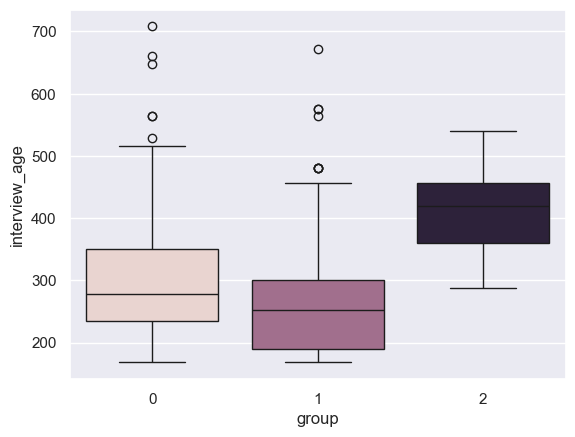

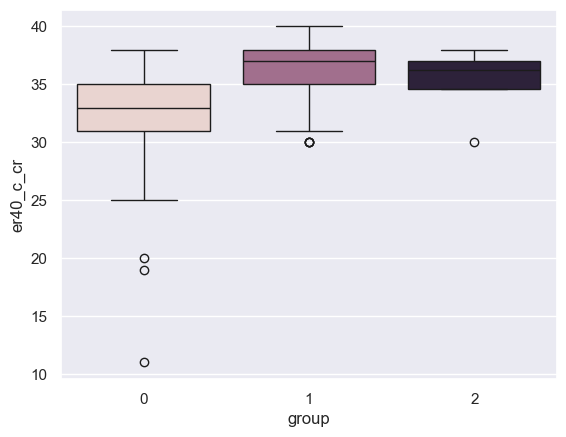

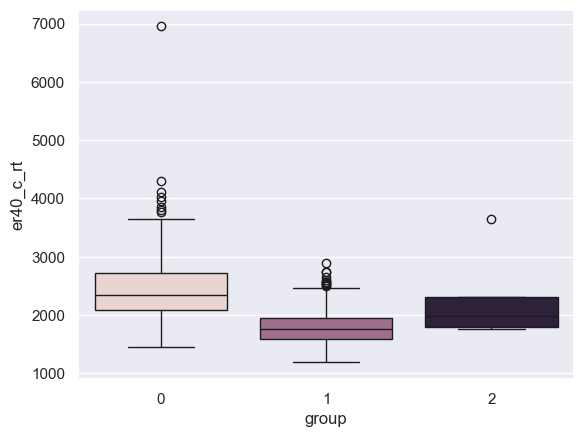

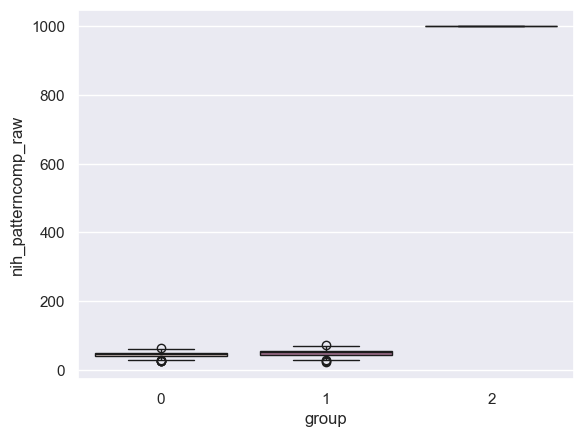

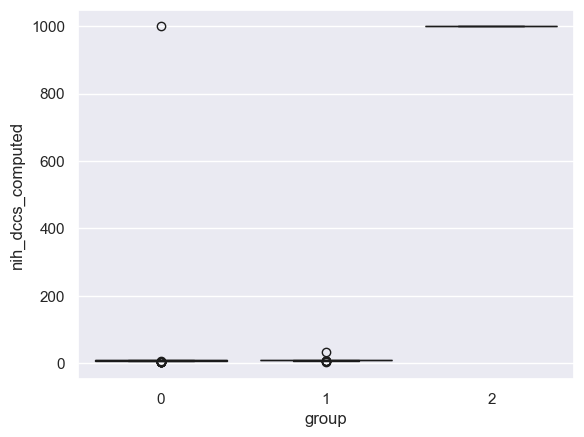

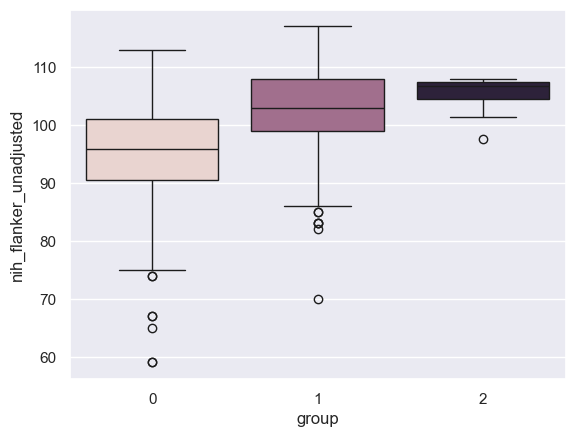

In [41]:
for val in vals:
    plot = sns.boxplot(data=plotting, x='group', y=val, hue='group')
    plot.get_legend().remove()
    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5507591892032282
For n_clusters = 3 The average silhouette_score is : 0.5556223557823264
For n_clusters = 4 The average silhouette_score is : 0.5534810771563192
For n_clusters = 5 The average silhouette_score is : 0.4753514235091343
For n_clusters = 6 The average silhouette_score is : 0.46061354986744724
For n_clusters = 7 The average silhouette_score is : 0.3925565178434485
For n_clusters = 8 The average silhouette_score is : 0.39119583161819305
For n_clusters = 9 The average silhouette_score is : 0.3932925408037009
For n_clusters = 10 The average silhouette_score is : 0.3794411082891845


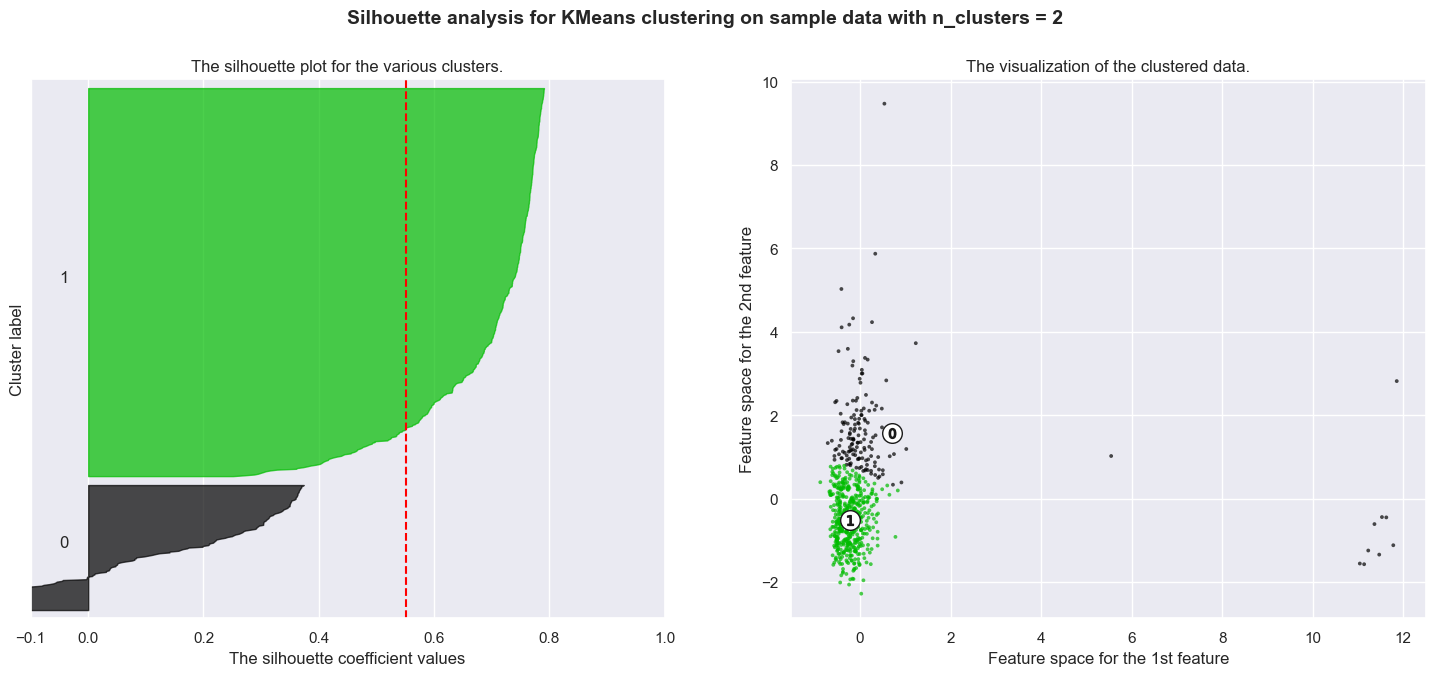

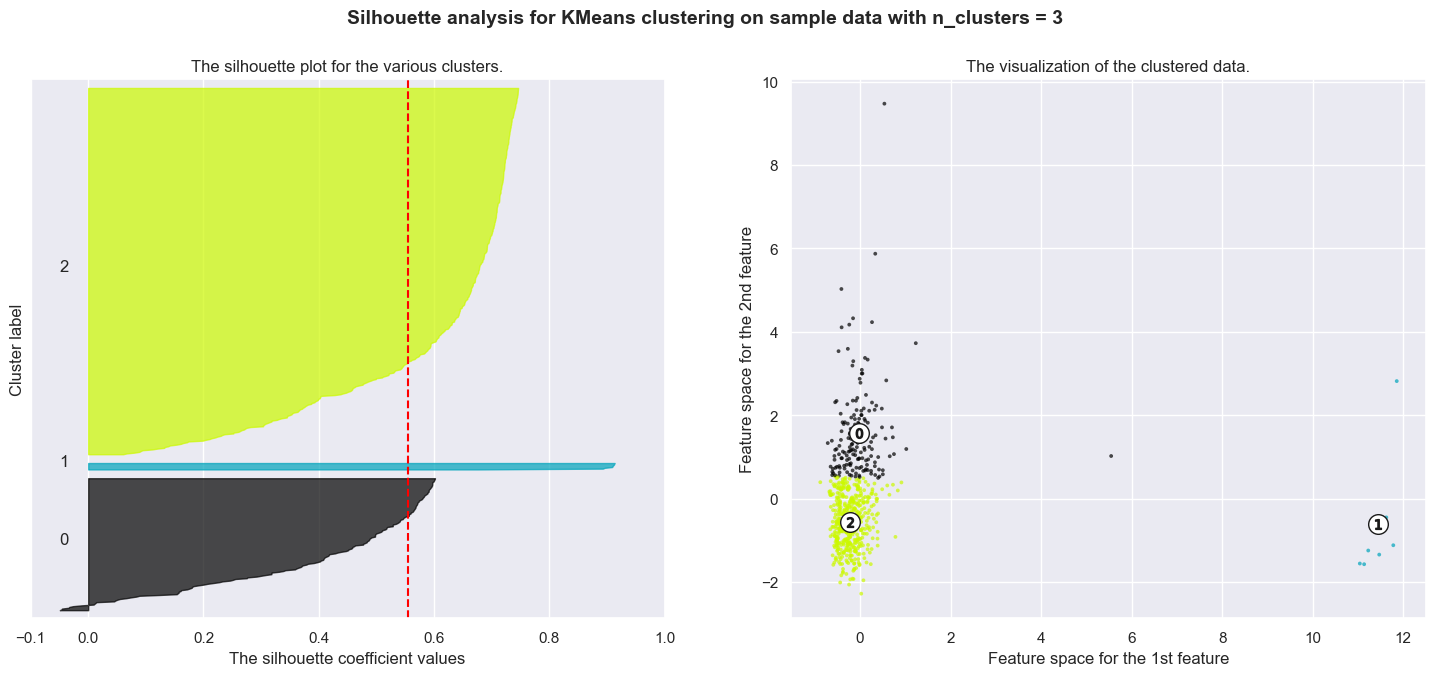

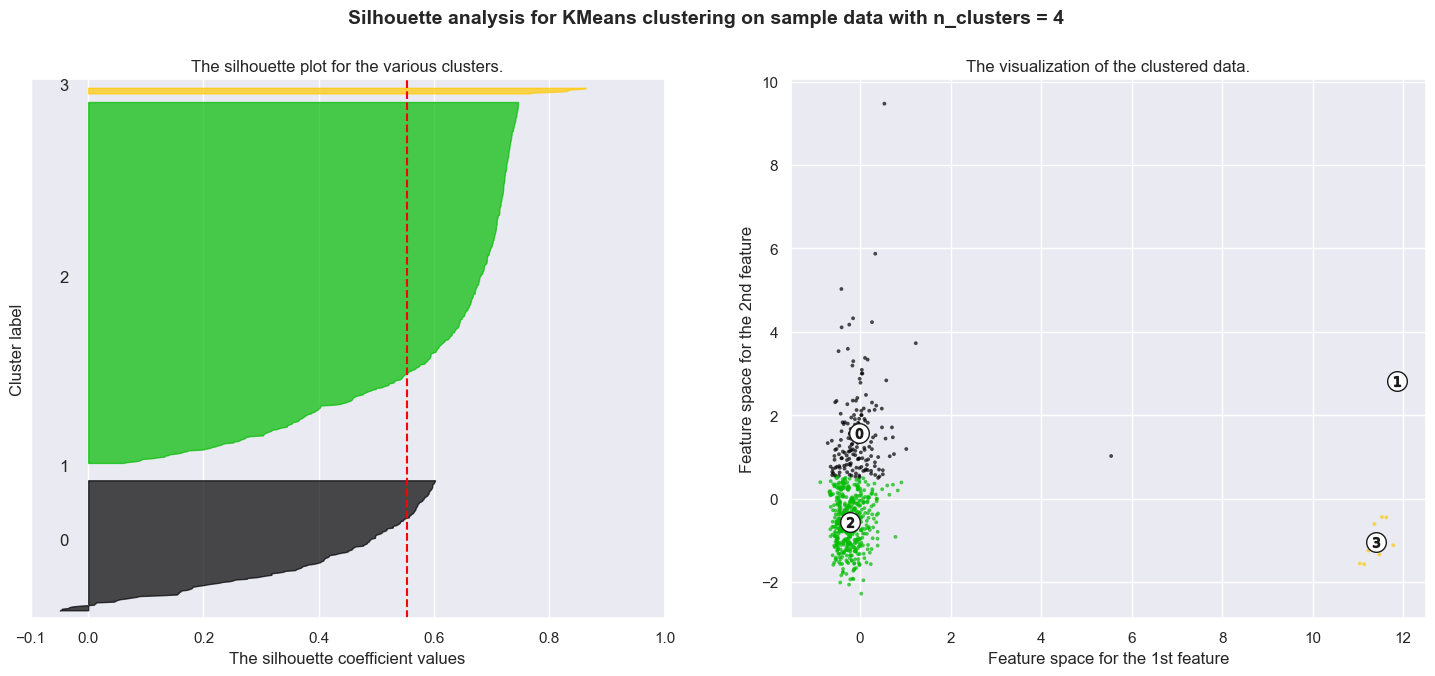

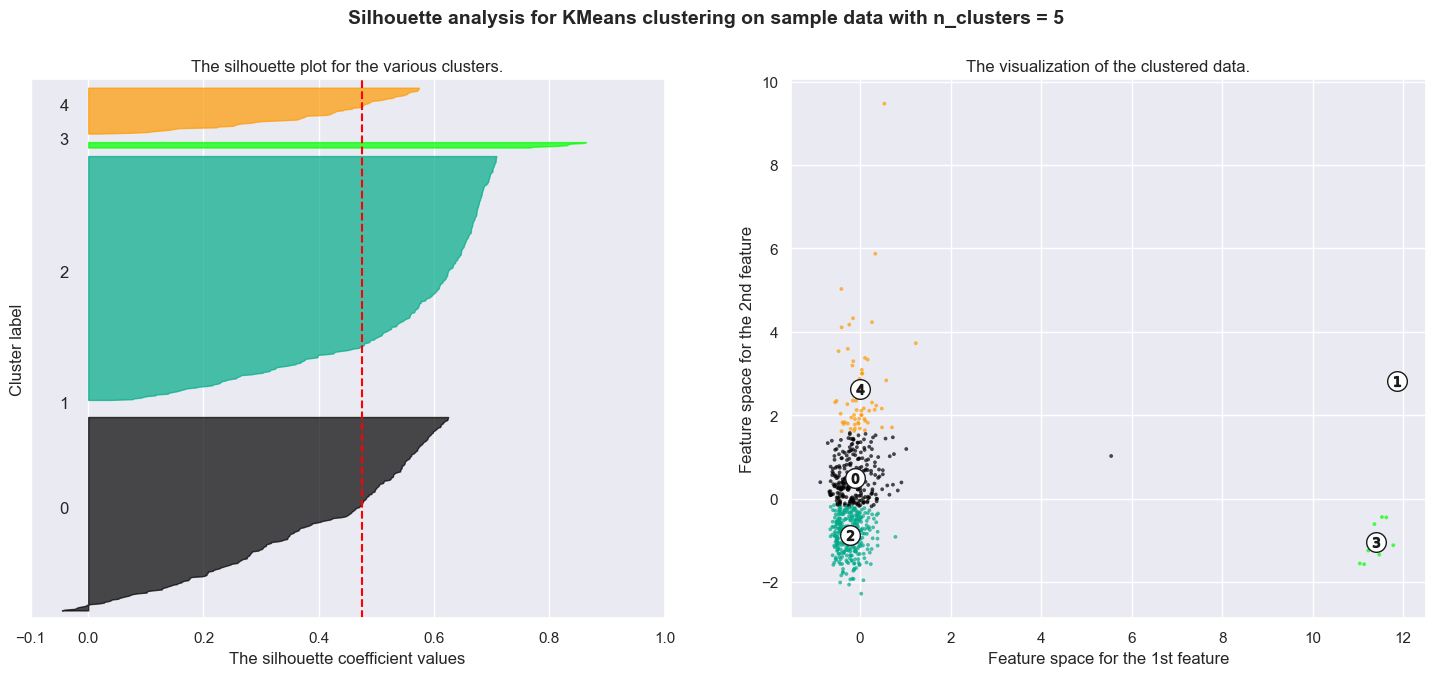

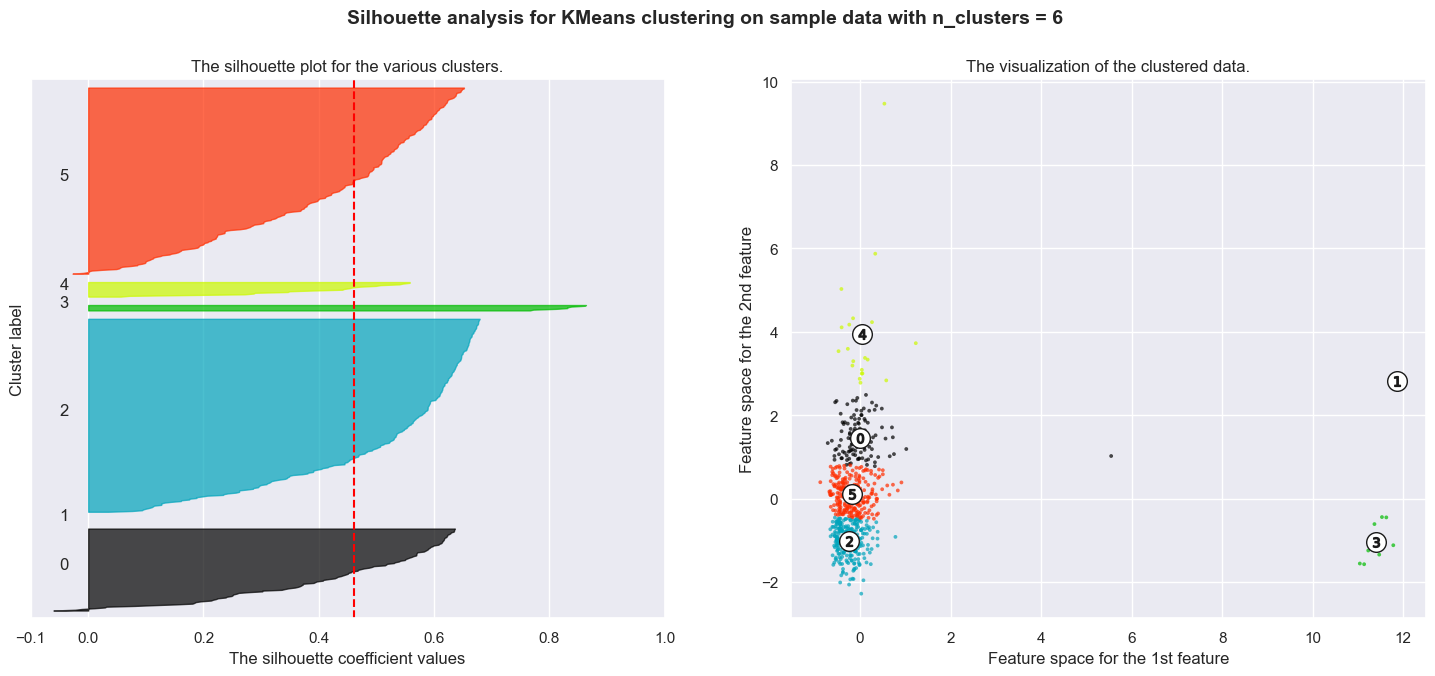

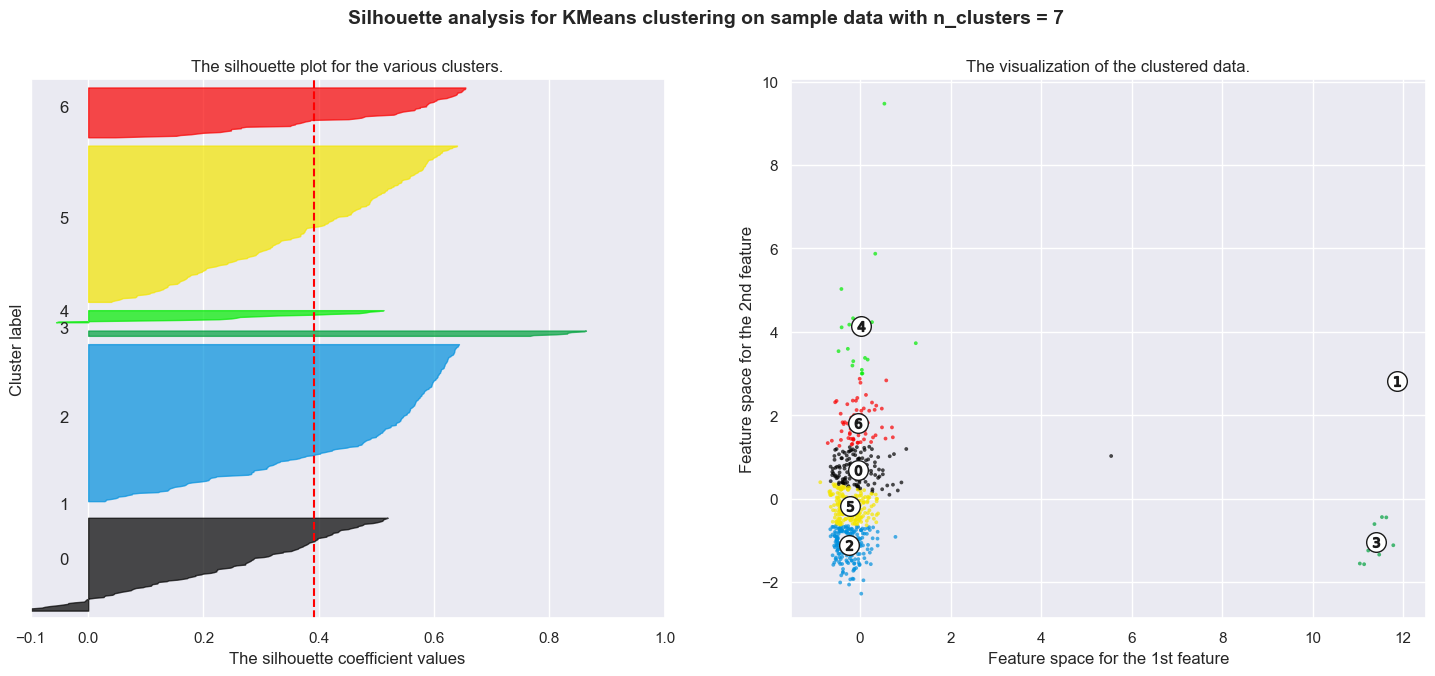

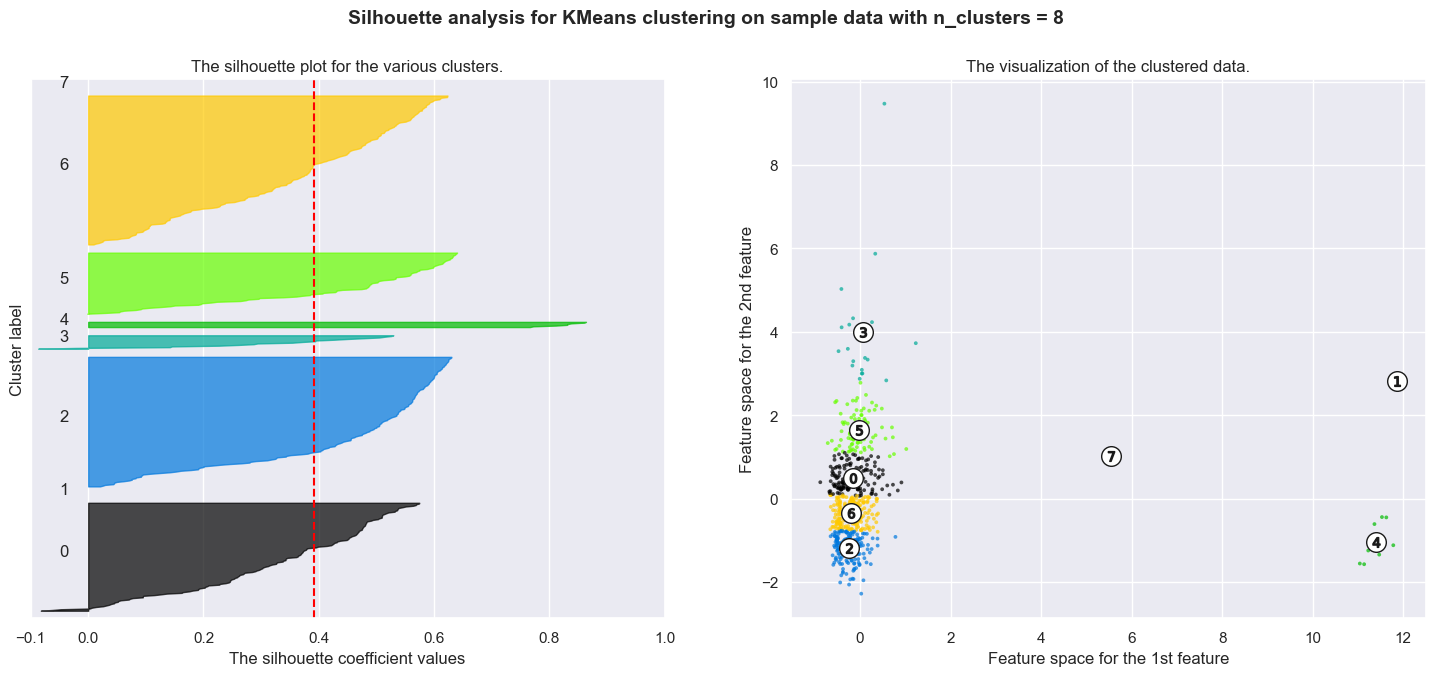

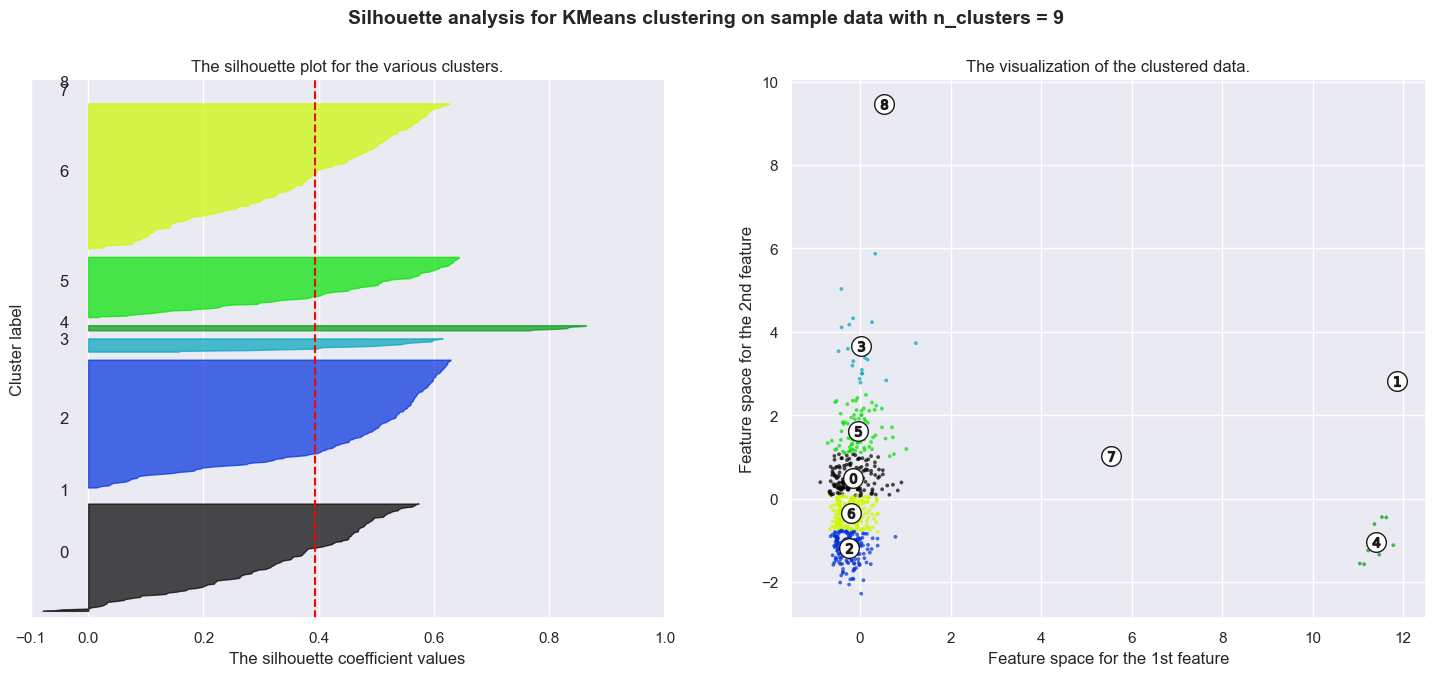

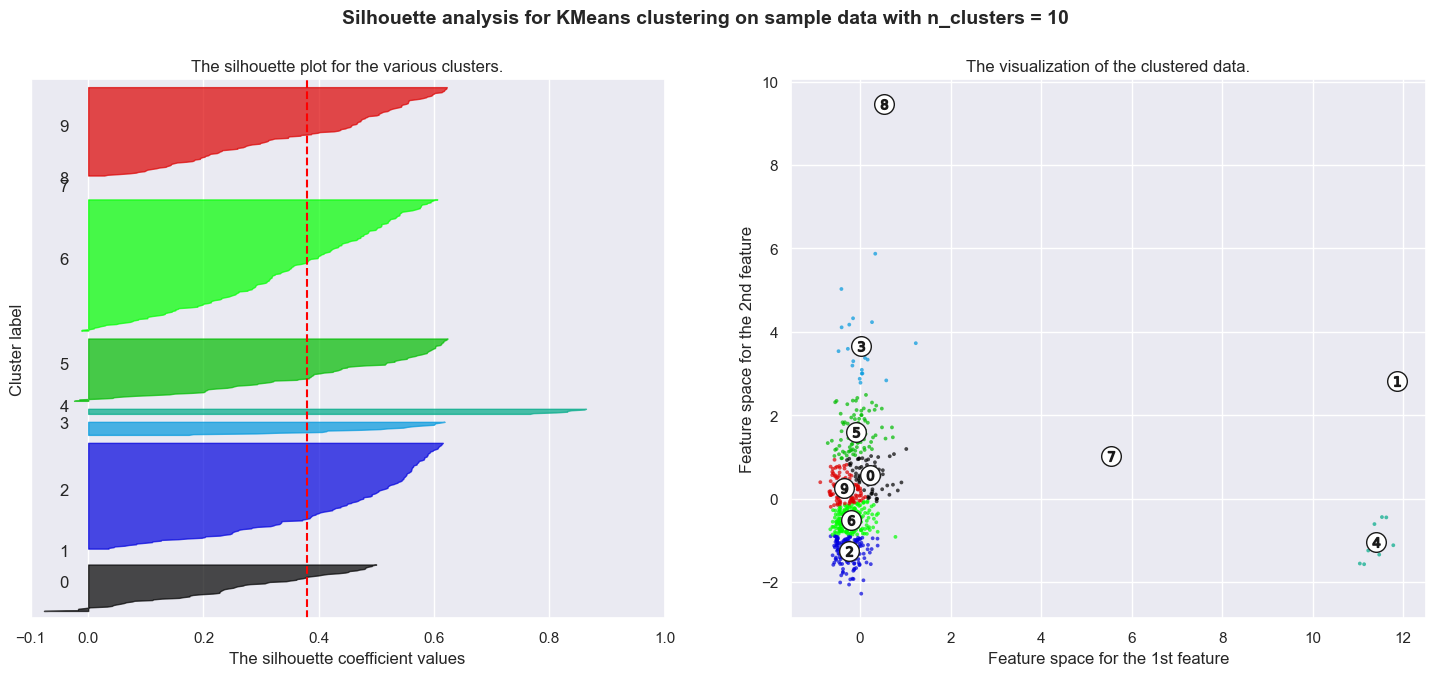

In [42]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = alt_pca # For reproducibility

for n_clusters in cluster_range:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()